# Pinwheel Test

Use a moving pinwheel to test the response of our filter bank

In [2]:
from PIL import Image, ImageSequence
import matplotlib.pyplot as plt
import numpy as np
import pickle
import torch
import torch.nn.functional as F


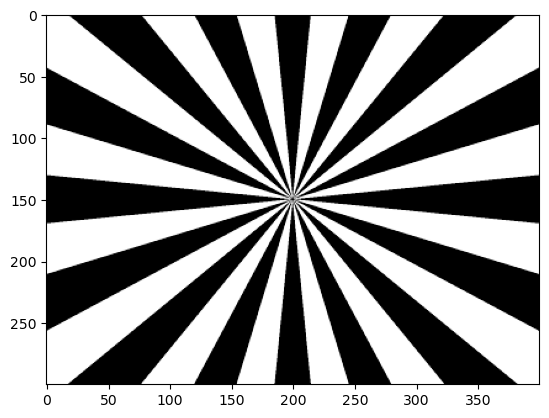

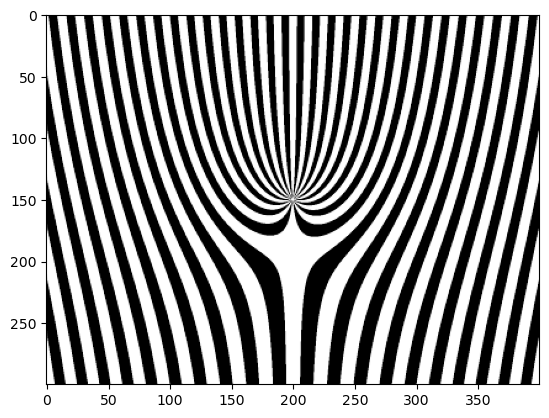

In [3]:
test_movie = './siemens_star/Rolling_Shutter_rotating_Siemens_star.gif'


movie = []
with Image.open(test_movie) as im:
    for frame in ImageSequence.Iterator(im):
        frame = np.array(frame)
        if(frame.ndim > 2):
            frame = np.mean(frame,axis=-1)
        movie.append(frame)
        #plt.imshow(frame)
        #plt.show()
#for f in movie:
#    print(f.shape,end='')

movie = np.array(movie)

movie = torch.from_numpy(np.array(movie))

plt.imshow(movie[1],cmap='Greys_r')
plt.show()
plt.imshow(movie[-1],cmap='Greys_r')
plt.show()


## Load in our Spatiotemporal Filter Bank

In [4]:
with open('./filter_banks/filters_torch.pkl', 'rb') as f:
    filters = pickle.load(f)

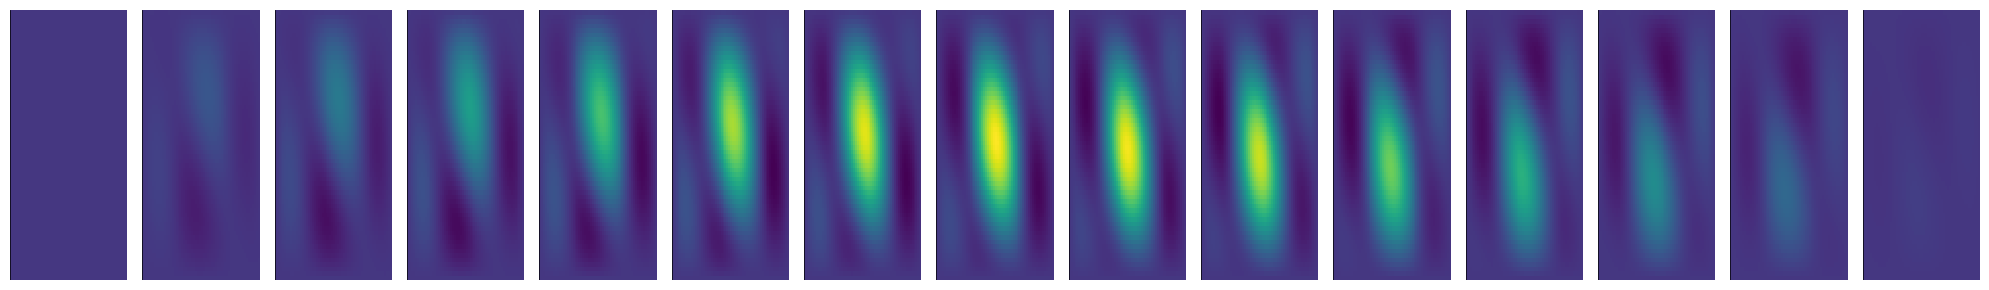

In [5]:
fig = plt.figure(figsize=(20, 3))
afilter = filters['spatiotemporal']['re']['1-0-0']
nslicestot = afilter.shape[0]
vmin = torch.min(afilter)
vmax = torch.max(afilter)
nslices = 15
slices = np.linspace(0,nslicestot-1,nslices,dtype=int)
f=0
for i in slices:
    f+=1
    plt.subplot(1,nslices,f)
    plt.pcolormesh(afilter[i,:,:],vmin=vmin,vmax=vmax)
    plt.axhline(0,color='black',linewidth = 0.5) # x = 0
    plt.axvline(0,color='black',linewidth = 0.5) # y = 0
    plt.axis('off')
plt.tight_layout()
plt.show()

## Convolve Filer Bank with Test Video

In [ ]:
movie = movie.unsqueeze(0).unsqueeze(0) 

real_output = []
imag_output = []
filter_names = list(filters['spatiotemporal']['re'].keys())
#loop thorugh filters
for filter_name in filter_names:
    real_filter = filters['spatiotemporal']['re'][filter_name].unsqueeze(0).unsqueeze(0) 
    imag_filter = filters['spatiotemporal']['im'][filter_name].unsqueeze(0).unsqueeze(0) 

    #shape of filters is [60,60,60]
    print(real_filter.shape, imag_filter.shape)
    #shape of movie is [301,300,400]
    print(movie.shape)
        
    # Convolve real part
    real_conv = F.conv3d(movie, real_filter, padding='same')
    real_output.append(real_conv)
    
    # Convolve imaginary part
    imag_conv = F.conv3d(movie, imag_filter, padding='same')
    imag_output.append(imag_conv)
    

torch.Size([1, 1, 60, 60, 60]) torch.Size([1, 1, 60, 60, 60])
torch.Size([1, 1, 301, 300, 400])


In [ ]:
movie.shape

In [ ]:
afilter.shape